In [777]:
import pandas as pd
import numpy as np
import scipy
import sklearn
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split ##split the data
from sklearn.feature_selection import RFE ##Test Features and select the best ones
from sklearn.linear_model import LogisticRegression ##Test Features and select the best ones
import statsmodels.api as sm ##Stats
from sklearn.metrics import confusion_matrix ##F1 score
from sklearn import preprocessing ##Normalize feature
import missingno as msno 
import datetime as dt
from itertools import product
from pandas_profiling import ProfileReport
from datetime import datetime
import calendar
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import KElbowVisualizer
from yellowbrick.cluster.elbow import kelbow_visualizer

In [778]:
donors = pd.read_csv("donors.csv", low_memory= False)

In [779]:
donors = donors.drop(columns = 'Unnamed: 0', errors = 'ignore')

# Missing Values

In [780]:
# NaN Counting
nan_count = donors.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors)

RAMNT_5     0.999906
RDATE_5     0.999906
RAMNT_3     0.997464
RDATE_3     0.997464
RDATE_4     0.997055
              ...   
DMA         0.001383
ADI         0.001383
MSA         0.001383
GEOCODE2    0.001383
FISTDATE    0.000021
Length: 92, dtype: float64

In [781]:
#Drop RFM columns from nan_counts
RDATE = nan_count[nan_count.index.str.contains("RDATE_")].index
RAMNT = nan_count[nan_count.index.str.contains("RAMNT_")].index
ADATE = nan_count[nan_count.index.str.contains("ADATE_")].index
nan_count = nan_count.drop(labels = RDATE)
nan_count = nan_count.drop(labels = RAMNT)
nan_count = nan_count.drop(labels = ADATE)

In [782]:
nan_count/len(donors)

NUMCHLD     0.870184
MBCOLECT    0.554584
MBCRAFT     0.553955
PUBOPP      0.553955
PUBPHOTO    0.553955
PUBNEWFN    0.553955
MBGARDEN    0.553955
PUBDOITY    0.553955
PUBHLTH     0.553955
PUBCULIN    0.553955
PUBGARDN    0.553955
MAGMALE     0.553955
MAGFEM      0.553955
MAGFAML     0.553955
MBBOOKS     0.553955
WEALTH1     0.468830
WEALTH2     0.459303
DOB         0.250314
INCOME      0.223096
TIMELAG     0.104526
NEXTDATE    0.104526
DMA         0.001383
ADI         0.001383
MSA         0.001383
GEOCODE2    0.001383
FISTDATE    0.000021
dtype: float64

In [783]:
#Delete Columns with more than 50% of Nan
columns_to_delete = ['NUMCHLD','MBCOLECT','PUBDOITY', 'PUBGARDN', 'PUBHLTH', 'MAGMALE','PUBNEWFN', 
                     'PUBPHOTO', 'PUBOPP', 'MAGFEM', 'MAGFAML', 'MBBOOKS','MBGARDEN', 
                     'MBCRAFT', 'PUBCULIN']
donors = donors.drop(columns = columns_to_delete)

In [784]:
nan_count = nan_count.drop(labels = columns_to_delete)

In [785]:
nan_count/len(donors)

WEALTH1     0.468830
WEALTH2     0.459303
DOB         0.250314
INCOME      0.223096
TIMELAG     0.104526
NEXTDATE    0.104526
DMA         0.001383
ADI         0.001383
MSA         0.001383
GEOCODE2    0.001383
FISTDATE    0.000021
dtype: float64

# Feature Eng.

In [786]:
#Last promotion date
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
lastpromotiondate.year

2017

In [787]:
#Create Variable Age
donors['DOB'] = donors['DOB'].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if pd.notnull(x) else x)
donors['AGE'] = lastpromotiondate.year - donors['DOB'].dt.year

In [788]:
#Create Function to count how many days to date.
def howmanydays(df, column, recent_year):
    df[column] = df[column].fillna('2017-06-01')
    df[column] = df[column].astype(str)
    df[column] = df[column].map(lambda x: datetime.strptime(x, '%Y-%m-%d') if pd.notnull(x) else x)
    df[column+'_days'] = (recent_year.
                       year - df[column].
                       dt.year)*12 + (recent_year.
                                      month - df[column].
                                      dt.month)

In [789]:
#Create Variable date_days for the date features.
for column in ['MAXADATE','MINRDATE','MAXRDATE','FISTDATE','NEXTDATE']:
    howmanydays(donors, column, lastpromotiondate)

In [790]:
#Split Variable DOMAIN wealth and type of neighbor.
donors['DOMAIN_LVL'] = donors['DOMAIN'].str.split('', expand = True)[1]
donors['DOMAIN_ECO'] = donors['DOMAIN'].str.split('', expand = True)[2]

In [791]:
#Create Variables for RFM_Promotion

rdate = donors[['RDATE_3','RDATE_4','RDATE_5','RDATE_6','RDATE_7','RDATE_8','RDATE_9','RDATE_10','RDATE_11','RDATE_12','RDATE_13','RDATE_14','RDATE_15','RDATE_16','RDATE_17','RDATE_18','RDATE_19','RDATE_20','RDATE_21','RDATE_22','RDATE_23','RDATE_24']]
rdate.columns = ['16NK','16TK','16SK','16LL','16G1','16GK','16CC','16WL','16X1','16XK','15FS','15NK','15TK','15LL','15G1','15GK','15CC','15WL','15X1','15XK','14FS','14NK']
rdate = rdate #  Date the gift was received for 16NK

ramnt = donors[['RAMNT_3','RAMNT_4','RAMNT_5','RAMNT_6','RAMNT_7','RAMNT_8','RAMNT_9','RAMNT_10','RAMNT_11','RAMNT_12','RAMNT_13','RAMNT_14','RAMNT_15','RAMNT_16','RAMNT_17','RAMNT_18','RAMNT_19','RAMNT_20','RAMNT_21','RAMNT_22','RAMNT_23','RAMNT_24']]
ramnt.columns = ['16NK','16TK','16SK','16LL','16G1','16GK','16CC','16WL','16X1','16XK','15FS','15NK','15TK','15LL','15G1','15GK','15CC','15WL','15X1','15XK','14FS','14NK']
ramnt = ramnt  #Dollar amount of the gift for 16NK

In [792]:
#Take the last date that the donor sent a gift with the first non null value from rows.
lastgiftdate = []
for i in range(0,len(rdate)):
    if rdate.iloc[i].isnull().sum() == 22:
        lastgiftdate.append(0)
    else:
        lastgiftdate.append(rdate.iloc[i][rdate.iloc[i].notnull()][0])

In [793]:
#Add Columns
rdate['lastgiftdate'] = lastgiftdate

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [794]:
#Transforming to Datetime
rdate.loc[:,'lastgiftdate'] = rdate.loc[:,'lastgiftdate'].map(lambda x: datetime.strptime(x, '%Y-%m-%d')
                                                              if not isinstance(x, int) else 0)

C:\Users\Luis\AppData\Roaming\Python\Python37\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [795]:
#Recency: Last promotion date in months
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
Recency = []
for i in rdate['lastgiftdate']:
    if i == 0:
        Recency.append(None)
    else:
        Recency.append((lastpromotiondate.year - i.year)*12 + (lastpromotiondate.month - i.month))

In [796]:
# Monetary sum of all gifts from donors/rows
Monetary = ramnt.sum(axis=1)

In [797]:
#Frequency count of how many times the donor gifted.
Frequency = ramnt.count(axis=1)

In [798]:
#Create Columns from RFM
donors['Recency'] = Recency
donors['Frequency'] = Frequency
donors['Monetary'] = Monetary

# Delete rows/donors that didn't gifted with the promotion.

In [799]:
delete_non_donors = donors[donors['Recency'].isnull()].index
donors.drop(index = delete_non_donors, inplace = True)

In [800]:
#Create score Classification for RFM_Promotion
donors['Recency_score'] = pd.qcut(donors['Recency'].rank(method='first'), q=5 , labels= (5,4,3,2,1))
donors['Recency_score'] = donors['Recency_score'].astype(int)
donors['Frequency_score'] = pd.qcut(donors['Frequency'].rank(method='first'), q=5 , labels= range(1,6))
donors['Frequency_score'] = donors['Frequency_score'].astype(int)
donors['Monetary_score'] = pd.qcut(donors['Monetary'].rank(method='first'), q=5 , labels= range(1,6))
donors['Monetary_score'] = donors['Monetary_score'].astype(int)

In [801]:
#Create RFM from Lifetime Donors

donors['Frequency_LTD'] = donors['NGIFTALL']
donors['Monetary_LTD'] = donors['AVGGIFT']

In [802]:
#Transform LASTDATE to create Recency
donors['LASTDATE'] = donors['LASTDATE'].map(lambda x: datetime.strptime(x, '%Y-%m-%d'))

In [803]:
#Create Recency from life time donors
lastpromotiondate = datetime.strptime('2017-06-01', '%Y-%m-%d')
lastpromotiondate.year
#Date associated with the most recent gift
donors['Recency_LTD'] = (lastpromotiondate.year - donors['LASTDATE']
                     .dt.year)*12 + (lastpromotiondate.month - donors['LASTDATE']
                                                                              .dt.month)

In [804]:
#Create star Classification for RFM
donors['Recency_LTD_score'] = pd.qcut(donors['Recency_LTD'].rank(method='first'), q=5 , labels= (5,4,3,2,1))
donors['Recency_LTD_score'] = donors['Recency_LTD_score'].astype(int)
donors['Frequency_LTD_score'] = pd.qcut(donors['Frequency_LTD'].rank(method='first'), q=5 , labels= range(1,6))
donors['Frequency_LTD_score'] = donors['Frequency_LTD_score'].astype(int)
donors['Monetary_LTD_score'] = pd.qcut(donors['Monetary_LTD'].rank(method='first'), q=5 , labels= range(1,6))
donors['Monetary_LTD_score'] = donors['Monetary_LTD_score'].astype(int)

In [805]:
#Create Variables sum and count for presents
def sum_by_column(df, new_col_name, list_of_cols_to_sum):
    df[new_col_name] = df[list_of_cols_to_sum].astype(float).sum(axis=1)
    return(df)

def count_by_column(df, new_col_name, list_of_cols_to_sum):
    df[new_col_name] = df[list_of_cols_to_sum].astype(float).count(axis=1)
    return(df)

In [806]:
GIFT = ramnt.copy()

# Aggregating by types and years
sum_by_column(GIFT, "16-labels", ['16LL','16WL'])
sum_by_column(GIFT, "15-labels", ['15LL','15WL'])
sum_by_column(GIFT, "16-calendars_with_stickers", ['16CC'])
sum_by_column(GIFT, "15-calendars_with_stickers", ['15CC'])
sum_by_column(GIFT, "15-blank_folding_cards_with_labels", ['15FS'])
sum_by_column(GIFT, "14-blank_folding_cards_with_labels", ['14FS'])
sum_by_column(GIFT, "16-blank_cards_with_labels", ['16NK','16SK'])
sum_by_column(GIFT, "15-blank_cards_with_labels", ['15NK'])
sum_by_column(GIFT, "14-blank_cards_with_labels", ['14NK'])
sum_by_column(GIFT, "16-thank_you_printed_with_labels", ['16TK'])
sum_by_column(GIFT, "15-thank_you_printed_with_labels", ['15TK'])
sum_by_column(GIFT, "16-general_greeting_cards_with_labels", ['16GK'])
sum_by_column(GIFT, "15-general_greeting_cards_with_labels", ['15GK'])
sum_by_column(GIFT, "16-christmas_cards_with_labels", ['16XK'])
sum_by_column(GIFT, "15-christmas_cards_with_labels", ['15XK'])
sum_by_column(GIFT, "16-notepad_with_labels", ['16X1','16G1'])
sum_by_column(GIFT, "15-notepad_with_labels", ['15X1','15G1'])

# Now summing by type of gift
sum_by_column(GIFT, "Just labels", ['16-labels','15-labels'])
sum_by_column(GIFT, "Calendars with stickers", ['16-calendars_with_stickers','15-calendars_with_stickers'])
sum_by_column(GIFT, "Blank folding cards with labels", ['15-blank_folding_cards_with_labels','14-blank_folding_cards_with_labels'])
sum_by_column(GIFT, "Blank cards with labels", ['16-blank_cards_with_labels','15-blank_cards_with_labels', '14-blank_cards_with_labels'])
sum_by_column(GIFT, "Thank you cards with labels", ['16-thank_you_printed_with_labels', '15-thank_you_printed_with_labels','16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Christmas Cards with labels", ['16-christmas_cards_with_labels', '15-christmas_cards_with_labels'])
sum_by_column(GIFT, "General Greeting Cards with Labels", ['16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Notepad with labels", ['16-notepad_with_labels', '15-notepad_with_labels'])

GIFT_sum = GIFT.iloc[:,-8:]

In [807]:
GIFT = ramnt.copy()

# Aggregating by types and years
count_by_column(GIFT, "16-labels", ['16LL','16WL'])
count_by_column(GIFT, "15-labels", ['15LL','15WL'])
count_by_column(GIFT, "16-calendars_with_stickers", ['16CC'])
count_by_column(GIFT, "15-calendars_with_stickers", ['15CC'])
count_by_column(GIFT, "15-blank_folding_cards_with_labels", ['15FS'])
count_by_column(GIFT, "14-blank_folding_cards_with_labels", ['14FS'])
count_by_column(GIFT, "16-blank_cards_with_labels", ['16NK','16SK'])
count_by_column(GIFT, "15-blank_cards_with_labels", ['15NK'])
count_by_column(GIFT, "14-blank_cards_with_labels", ['14NK'])
count_by_column(GIFT, "16-thank_you_printed_with_labels", ['16TK'])
count_by_column(GIFT, "15-thank_you_printed_with_labels", ['15TK'])
count_by_column(GIFT, "16-general_greeting_cards_with_labels", ['16GK'])
count_by_column(GIFT, "15-general_greeting_cards_with_labels", ['15GK'])
count_by_column(GIFT, "16-christmas_cards_with_labels", ['16XK'])
count_by_column(GIFT, "15-christmas_cards_with_labels", ['15XK'])
count_by_column(GIFT, "16-notepad_with_labels", ['16X1','16G1'])
count_by_column(GIFT, "15-notepad_with_labels", ['15X1','15G1'])

# Now summing by type of gift
sum_by_column(GIFT, "Just labels_count", ['16-labels','15-labels'])
sum_by_column(GIFT, "Calendars with stickers_count", ['16-calendars_with_stickers','15-calendars_with_stickers'])
sum_by_column(GIFT, "Blank folding cards with labels_count", ['15-blank_folding_cards_with_labels','14-blank_folding_cards_with_labels'])
sum_by_column(GIFT, "Blank cards with labels_count", ['16-blank_cards_with_labels','15-blank_cards_with_labels', '14-blank_cards_with_labels'])
sum_by_column(GIFT, "Thank you cards with labels_count", ['16-thank_you_printed_with_labels', '15-thank_you_printed_with_labels','16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Christmas Cards with labels_count", ['16-christmas_cards_with_labels', '15-christmas_cards_with_labels'])
sum_by_column(GIFT, "General Greeting Cards with Labels_count", ['16-general_greeting_cards_with_labels','15-general_greeting_cards_with_labels'])
sum_by_column(GIFT, "Notepad with labelss_count", ['16-notepad_with_labels', '15-notepad_with_labels'])

GIFT_count = GIFT.iloc[:,-8:]

In [808]:
donors = pd.concat([donors, GIFT_sum, GIFT_count], axis = 1)

In [809]:
#Delete non donors Ids after gift table.
donors.drop(index = delete_non_donors, inplace = True)

In [810]:
#Fill Nan From GEOCODE2
donors['GEOCODE2'].fillna(' ', inplace = True)

# Feature Selection

# Separate the variables
# Financial information
- INCOME                      HOUSEHOLD INCOME -> **KNN IMPUTER**
- WEALTH1                     Wealth Rating -> **KNN IMPUTER**    
- WEALTH2                     Wealth Rating -> **KNN IMPUTER**
# Geographic information
- STATE                       State abbreviation (a nominal/symbolic field) -> **DELETE**
- ZIP                         Zipcode (a nominal/symbolic field) -> **DELETE**
- MAILCODE                    Mail Code ->
- PVASTATE                    EPVA State or PVA State -> 
- DOMAIN                      DOMAIN/Cluster code. A nominal or symbolic field. -> **'DISCRETIZING'**
- GEOCODE                     Geo Cluster Code indicating the level geography at which -> 
# Donation History
- OSOURCE                     Origin Source -> **DELETE**
- MDMAUD                      The Major Donor Matrix code -> **DELETE**
- MAJOR                       Major Donor Flag ->
- PEPSTRFL                    Indicates PEP Star RFA Status -> 
- HIT                         MOR Flag HIT (Mail Order Response) -> 
# ID information
- ODATEDW                     Origin Date. Date of donors first gift -> **'DELETE'**
- TCODE                       Donor title code -> **'DELETE'**
- DOB                         Date of birth (YYMM, Year/Month format.) -> **DELETE**
- CHILD03                     Presence of Children age 0-3 -> 
- CHILD07                     Presence of Childern age 4-7 ->
- CHILD12                     Presence of Childern age 8-12 ->
- CHILD18                     Presence of Childern age 13-18 -> 
- NUMCHLD                     NUMBER OF CHILDREN -> **DELETE**
- GENDER                      Gender -> 
- DATASRCE                    Source of Overlay Data -> **'DELETE'**
- MALEMILI                    % Males active in the Military -> 
- MALEVET                     % Males Veterans -> 
- VIETVETS                    % Vietnam Vets -> 
- WWIIVETS                    % WWII Vets -> 
- LOCALGOV                    % Employed by Local Gov -> 
- STATEGOV                    % Employed by State Gov ->
- FEDGOV                      % Employed by Fed Gov -> 
- COLLECT1                    COLLECTABLE (Y/N) ->
- VETERANS                    VETERANS (Y/N) -> 
- BIBLE                       BIBLE READING (Y/N) -> 
- CATLG                       SHOP BY CATALOG (Y/N) ->
- HOMEE                       WORK FROM HOME (Y/N) -> 
- PETS                        HOUSEHOLD PETS (Y/N) -> 
- CDPLAY                      CD PLAYER OWNERS (Y/N) -> 
- STEREO                      STEREO/RECORDS/TAPES/CD (Y/N) -> 
- PCOWNERS                    HOME PC OWNERS/USERS ->
- PHOTO                       PHOTOGRAPHY (Y/N) -> 
- CRAFTS                      CRAFTS (Y/N) -> 
- FISHER                      FISHING (Y/N) ->
- GARDENIN                    GARDENING (Y/N) -> 
- BOATS                       POWER BOATING (Y/N) ->
- WALKER                      WALK FOR HEALTH (Y/N) -> 
- KIDSTUFF                    BUYS CHILDRENS PRODUCTS (Y/N) -> 
- CARDS                       STATIONARY/CARDS BUYER (Y/N) -> 
- PLATES                      PLATE COLLECTOR (Y/N) -> 
- LIFESRC                     LIFE STYLE DATA SOURCE/ SAME AS DATASRCE -> **'DELETE'**
- HOMEOWNR                    Home Owner Flag -> 

# Data permission for ID information
- NOEXCH                      Do Not Exchange Flag (For list rental) -> 
- RECINHSE                    In House File Flag -> 
- RECP3                       P3 File Flag -> 
- RECPGVG                     Planned Giving File Flag ->
- RECSWEEP                    Sweepstakes file fla g -> 
# Unknown 
- SOLP3                       SOLICIT LIMITATION CODE P3 ->
- SOLIH                       SOLICITATION LIMIT CODE IN HOUSE -> 

# N. information everything is ok.

# RFM information

- ADATE_K **DELETE**
- RFA_K **DELETE**
- RDATE_K **DELETE**
- RAMNT_K **DELETE**
- FISTDATE **DELETE**
- NEXTDATE **DELETE**

In [811]:
# Delete RFM information
RFA_columns_delete = donors.columns[donors.columns.str.contains('RFA_')]
RAMNT_columns_delete = donors.columns[donors.columns.str.contains('RAMNT_')]
RDATE_columns_delete = donors.columns[donors.columns.str.contains('RDATE_')]
ADATA_columns_delete = donors.columns[donors.columns.str.contains('ADATE_')]
MDMAUD_columns_delete = donors.columns[donors.columns.str.contains('MDMAUD_')]

donors = donors.drop(columns = RFA_columns_delete, errors = 'ignore')
donors = donors.drop(columns = RAMNT_columns_delete, errors = 'ignore')
donors = donors.drop(columns = RDATE_columns_delete, errors = 'ignore')
donors = donors.drop(columns = ADATA_columns_delete, errors = 'ignore')
donors = donors.drop(columns = MDMAUD_columns_delete, errors = 'ignore')
donors = donors.drop(columns = ['FISTDATE','NEXTDATE','MAXADATE','MINRDATE','MAXRDATE','FISTDATE','NEXTDATE','LASTDATE'], 
                     errors = 'ignore')

In [812]:
# Delete Geographic information
Geo_delete_columns = ['STATE', 'ZIP']
donors = donors.drop(columns = Geo_delete_columns, errors = 'ignore')

In [813]:
# Delete Donation History
Don_delete_columns = ['OSOURCE', 'MDMAUD']
donors = donors.drop(columns = Don_delete_columns, errors = 'ignore')

In [814]:
# Delete ID Information
ID_delete_columns = ['TCODE','ODATEDW', 'DOB', 'NUMCHLD', 'DATASRCE', 'LIFESRC']
donors = donors.drop(columns = ID_delete_columns, errors = 'ignore')

In [815]:
# NaN Counting
nan_count = donors.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors)

WEALTH1    0.468954
WEALTH2    0.459099
AGE        0.250454
INCOME     0.223177
TIMELAG    0.100798
MSA        0.001393
ADI        0.001393
DMA        0.001393
dtype: float64

## OHE

In [816]:
nonmetric_features = donors.dtypes[(donors.dtypes == 'object')].index.to_list()

In [817]:
len(nonmetric_features)

40

In [818]:
nonmetric_features

['MAILCODE',
 'PVASTATE',
 'NOEXCH',
 'RECINHSE',
 'RECP3',
 'RECPGVG',
 'RECSWEEP',
 'DOMAIN',
 'HOMEOWNR',
 'CHILD03',
 'CHILD07',
 'CHILD12',
 'CHILD18',
 'GENDER',
 'SOLP3',
 'SOLIH',
 'MAJOR',
 'GEOCODE',
 'COLLECT1',
 'VETERANS',
 'BIBLE',
 'CATLG',
 'HOMEE',
 'PETS',
 'CDPLAY',
 'STEREO',
 'PCOWNERS',
 'PHOTO',
 'CRAFTS',
 'FISHER',
 'GARDENIN',
 'BOATS',
 'WALKER',
 'KIDSTUFF',
 'CARDS',
 'PLATES',
 'PEPSTRFL',
 'GEOCODE2',
 'DOMAIN_LVL',
 'DOMAIN_ECO']

In [819]:
train_data_standard_ohe = donors.copy()
ohc = OneHotEncoder(sparse=False, drop = 'if_binary')
ohc_feat = ohc.fit_transform(train_data_standard_ohe[nonmetric_features])
ohc_feat_names = ohc.get_feature_names()
ohc_df = pd.DataFrame(ohc_feat, index=train_data_standard_ohe[nonmetric_features].index, columns=ohc_feat_names)  # Why the index=df_ohc.index?
ohc_df


,x0_B,x1_,x1_E,x1_P,x2_,x2_0,x2_1,x2_X,x3_X,x4_X,...,x38_C,x38_R,x38_S,x38_T,x38_U,x39_,x39_1,x39_2,x39_3,x39_4
0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95407,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
95408,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
95409,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
95410,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


In [820]:
metric_features = donors.columns.to_list()
for i in nonmetric_features:
    metric_features.remove(i)

In [821]:
donors = pd.concat([donors[metric_features],
                            ohc_df],
                           axis = 1)

In [822]:
donors.head()

,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,...,x38_C,x38_R,x38_S,x38_T,x38_U,x39_,x39_1,x39_2,x39_3,x39_4
0,NaN,NaN,0.0,0.0,39.0,34.0,18.0,10.0,2.0,1.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,6.0,9.0,16.0,0.0,15.0,55.0,11.0,6.0,2.0,1.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3.0,1.0,2.0,0.0,20.0,29.0,33.0,6.0,8.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1.0,4.0,2.0,0.0,23.0,14.0,31.0,3.0,0.0,3.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,3.0,2.0,60.0,1.0,28.0,9.0,53.0,26.0,3.0,2.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# Detecting OutLiers

In [823]:
from sklearn.neighbors import LocalOutlierFactor

In [824]:
nan_columns = donors.isnull().sum()[(donors.isnull().sum() > 0)].index.to_list()
non_nan = donors.columns.to_list()
for i in nan_columns:
    non_nan.remove(i)

In [825]:
# model specification
model1 = LocalOutlierFactor(n_neighbors = 8)
# model fitting
y_pred = model1.fit_predict(donors[non_nan])

In [826]:
# filter outlier index
outlier_index = (y_pred == -1) # negative values are outliers and positives inliers
# filter outlier values
outlier_values = donors[non_nan].iloc[outlier_index]

In [827]:
#Delete Outliers to fill NaN
donors.drop(index = outlier_values.index, inplace = True)

# Fill Na Values

In [828]:
# NaN Counting
nan_count = donors.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors)

WEALTH1    0.466061
WEALTH2    0.458402
AGE        0.248414
INCOME     0.220671
TIMELAG    0.100495
DMA        0.001306
ADI        0.001306
MSA        0.001306
dtype: float64

In [829]:
#Check correlation
income_cor = donors.corr()

In [830]:
age_fill = income_cor['AGE'][(income_cor['AGE'].
                              sort_values()>0.15) | (income_cor['AGE'].
                                                     sort_values()<-0.15)].index.to_list()

In [831]:
income_fill = income_cor['INCOME'][(income_cor['INCOME'].
                                    sort_values()>0.3) | (income_cor['INCOME'].
                                                          sort_values()<-0.3)].index.to_list()

In [832]:
income_cor['INCOME'][(income_cor['INCOME'].
                                    sort_values()>0.3) | (income_cor['INCOME'].
                                                          sort_values()<-0.3)]

INCOME     1.000000
WEALTH1    0.455252
WEALTH2    0.406738
HV1        0.325918
HV2        0.336236
HV3        0.336260
HV4        0.319555
HVP2       0.319183
HVP3       0.354283
HVP4       0.362560
HVP5       0.321361
HUR2       0.307362
RP1        0.325911
RP2        0.308076
IC1        0.426462
IC2        0.415894
IC3        0.441344
IC4        0.429138
IC5        0.358515
IC6       -0.371052
IC7       -0.346326
IC10       0.352656
IC11       0.385416
IC12       0.340462
IC15      -0.328576
IC16      -0.354619
IC19       0.320722
IC20       0.370008
IC21       0.327027
OCC2       0.335813
EC1        0.302140
EC3       -0.302568
EC7        0.352240
EC8        0.312072
MHUC1      0.331434
x8_H       0.323870
x8_U      -0.325138
x39_1      0.379449
Name: INCOME, dtype: float64

In [833]:
imputer = KNNImputer(n_neighbors=8, weights="uniform")
fill_na_income = imputer.fit_transform(donors[income_fill])

In [834]:
imputer = KNNImputer(n_neighbors=8, weights="uniform")
fill_na_age = imputer.fit_transform(donors[age_fill])

In [835]:
donors[income_fill] = fill_na_income
donors[age_fill] = fill_na_age

In [836]:
donors['INCOME'] = round(donors['INCOME'],0)
donors['WEALTH1'] = round(donors['WEALTH1'],0)
donors['WEALTH2'] = round(donors['WEALTH2'],0)
donors['AGE'] = round(donors['AGE'],0)

In [837]:
# NaN Counting
nan_count = donors.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors)

TIMELAG    0.100495
DMA        0.001306
ADI        0.001306
MSA        0.001306
dtype: float64

In [838]:
DMA_na = donors[donors['DMA'].isnull()].index.to_list()
drop_na = DMA_na

In [839]:
donors.drop(index = drop_na, inplace = True)

In [840]:
nan_count = donors.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors)

TIMELAG    0.100496
dtype: float64

In [841]:
#TIMELAG is a real NaN
donors['TIMELAG'].fillna(0, inplace = True)

# Outliars check

In [842]:
# model specification
model1 = LocalOutlierFactor(n_neighbors = 8)
# model fitting
y_pred = model1.fit_predict(donors)

In [843]:
# filter outlier index
outlier_index = (y_pred == -1) # negative values are outliers and positives inliers
# filter outlier values
outlier_values = donors.iloc[outlier_index]

In [844]:
#Delete Outliers to fill NaN
donors.drop(index = outlier_values.index, inplace = True)

In [845]:
len(donors)

89303

# Feature Selection

In [848]:
donors_corr = donors.corr().loc[:,['Recency_score','Frequency_score', 'Monetary_score']]

In [850]:
donors_corr['Total'] = donors_corr.loc[:,['Recency_score','Frequency_score', 'Monetary_score']].pow(2).sum(axis = 1)
high_corr = donors_corr.sort_values(by = 'Total').tail(40).index.to_list()
high_corr

['NEXTDATE_days',
 'Christmas Cards with labels',
 'Notepad with labels',
 'MAXRAMNT',
 'NUMPRM12',
 'General Greeting Cards with Labels',
 'LASTGIFT',
 'Just labels',
 'AVGGIFT',
 'Monetary_LTD',
 'MINRAMNT',
 'Thank you cards with labels',
 'Calendars with stickers_count',
 'NUMPROM',
 'Blank folding cards with labels',
 'Blank cards with labels',
 'Christmas Cards with labels_count',
 'CARDPROM',
 'Notepad with labelss_count',
 'RAMNTALL',
 'Just labels_count',
 'x36_X',
 'CARDGIFT',
 'Monetary_LTD_score',
 'General Greeting Cards with Labels_count',
 'Frequency_LTD',
 'NGIFTALL',
 'Blank folding cards with labels_count',
 'Thank you cards with labels_count',
 'Blank cards with labels_count',
 'CARDPM12',
 'Frequency_LTD_score',
 'Recency_LTD',
 'Monetary',
 'Recency_LTD_score',
 'Recency',
 'Recency_score',
 'Frequency',
 'Monetary_score',
 'Frequency_score']

# Scale Data

In [851]:
deleted_features = ['Recency_LTD', 'Frequency', 'Recency', 'NEXTDATE_days', 'Frequency_LTD', 'Monetary', 'Monetary_LTD', 'FISTDATE_days']
for i in deleted_features:
    metric_features.remove(i)

In [852]:
donors_scaled = donors.copy()

In [853]:
# Use MinMaxScaler to scale the data
scaler = StandardScaler()
scaled_feat = scaler.fit_transform(donors_scaled[metric_features])
scaled_feat

array([[ 0.0774903 , -0.05261561, -0.35760605, ..., -0.78443826,
        -0.7376408 ,  0.82313891],
       [ 1.25991086,  1.50972249,  1.34214776, ..., -0.78443826,
        -0.7376408 , -0.68103081],
       [-0.51371998, -1.61495372, -0.14513683, ...,  2.38852533,
         0.94658747, -0.68103081],
       ...,
       [ 1.85112114,  1.50972249, -0.25137144, ..., -0.78443826,
        -0.7376408 ,  0.82313891],
       [ 0.0774903 , -0.83378466, -0.35760605, ...,  2.38852533,
         2.63081574, -0.68103081],
       [ 1.85112114,  0.72855344, -0.35760605, ...,  0.80204354,
         0.94658747,  2.32730863]])

In [854]:
donors_scaled[metric_features] = scaled_feat
donors_scaled.head()

,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,...,x38_C,x38_R,x38_S,x38_T,x38_U,x39_,x39_1,x39_2,x39_3,x39_4
0,0.077490,-0.052616,-0.357606,-0.215618,0.742733,0.281631,-0.838889,0.720960,-0.504959,-0.515597,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
1,1.259911,1.509722,1.342148,-0.215618,-1.374969,1.682950,-1.237468,-0.200142,-0.504959,-0.515597,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,-0.513720,-1.614954,-0.145137,-0.215618,-0.933781,-0.052016,0.015208,-0.200142,0.680149,-0.515597,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,-1.696141,-0.443200,-0.145137,-0.215618,-0.669069,-1.052957,-0.098672,-0.890969,-0.899995,-0.023231,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,-0.513720,-1.224369,6.016471,0.001596,-0.227881,-1.386605,1.154004,4.405367,-0.307441,-0.269414,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


# PCA

In [855]:
# NaN Counting
nan_count = donors_scaled.isnull().sum().sort_values(ascending = False)
nan_count = nan_count[nan_count != 0]
nan_count/len(donors_scaled)

Series([], dtype: float64)

In [858]:
# Use PCA to reduce dimensionality of data
pca = PCA()
pca_feat = pca.fit_transform(donors_scaled[metric_features])
pca_feat  # What is this output?

array([[ 1.69760534e+00, -4.45062939e+00,  4.55119913e+00, ...,
         4.46990173e-03,  6.63507080e-03, -2.09801182e-05],
       [-2.02302179e+01,  1.50049563e+00, -3.14296884e+00, ...,
        -3.86541755e-04,  4.65417163e-04,  9.63582114e-06],
       [ 4.72181953e+00, -5.54608796e+00,  2.80544674e+00, ...,
        -9.80529301e-04,  6.81704471e-03, -5.56356551e-05],
       ...,
       [-1.39138685e+01, -4.16022241e+00, -1.50126690e+00, ...,
        -4.99142927e-04,  9.48313760e-03, -4.49926133e-04],
       [ 3.26935548e+00, -2.45999414e+00, -4.94010403e+00, ...,
        -3.20975420e-03,  4.41728619e-04, -5.68694321e-06],
       [-9.64802995e+00, -6.72776673e-01, -7.48425402e-01, ...,
         5.24475307e-03, -8.63937053e-04, -1.06610987e-04]])

In [859]:
# Output PCA table
pd.DataFrame(
    {"Eigenvalue": pca.explained_variance_,
     "Difference": np.insert(np.diff(pca.explained_variance_), 0, 0),
     "Proportion": pca.explained_variance_ratio_,
     "Cumulative": np.cumsum(pca.explained_variance_ratio_)},
    index=range(1, pca.n_components_ + 1)
).head(20)

,Eigenvalue,Difference,Proportion,Cumulative
1,41.134420,0.000000,0.123156,0.123156
2,30.143816,-10.990604,0.090250,0.213406
3,25.545693,-4.598123,0.076483,0.289889
4,12.907605,-12.638088,0.038645,0.328534
5,12.367898,-0.539707,0.037029,0.365563
6,9.491630,-2.876268,0.028418,0.393981
7,7.358647,-2.132983,0.022032,0.416012
8,7.262633,-0.096014,0.021744,0.437757
9,6.744235,-0.518398,0.020192,0.457949
10,6.012046,-0.732188,0.018000,0.475949


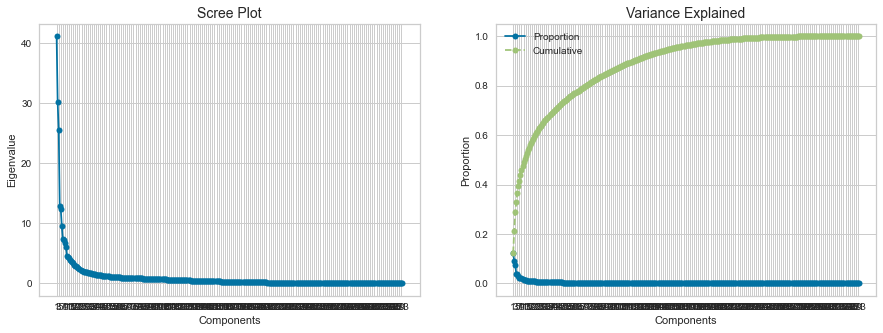

In [860]:
# figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# draw plots
ax1.plot(pca.explained_variance_, marker=".", markersize=12)
ax2.plot(pca.explained_variance_ratio_, marker=".", markersize=12, label="Proportion")
ax2.plot(np.cumsum(pca.explained_variance_ratio_), marker=".", markersize=12, linestyle="--", label="Cumulative")

# customizations
ax2.legend()
ax1.set_title("Scree Plot", fontsize=14)
ax2.set_title("Variance Explained", fontsize=14)
ax1.set_ylabel("Eigenvalue")
ax2.set_ylabel("Proportion")
ax1.set_xlabel("Components")
ax2.set_xlabel("Components")
ax1.set_xticks(range(0, pca.n_components_, 2))
ax1.set_xticklabels(range(1, pca.n_components_ + 1, 2))
ax2.set_xticks(range(0, pca.n_components_, 2))
ax2.set_xticklabels(range(1, pca.n_components_ + 1, 2))

plt.show()

In [861]:
donors_scaled

,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.077490,-0.052616,-0.357606,-0.215618,0.742733,0.281631,-0.838889,0.720960,-0.504959,-0.515597,...,1.697803,-4.451761,4.549998,-0.704751,-0.446860,-2.585954,-5.269436,0.602134,0.418572,0.084554
1,1.259911,1.509722,1.342148,-0.215618,-1.374969,1.682950,-1.237468,-0.200142,-0.504959,-0.515597,...,-20.230046,1.500889,-3.142551,-6.959073,9.557978,4.123645,1.546674,4.870810,0.102183,-0.114036
2,-0.513720,-1.614954,-0.145137,-0.215618,-0.933781,-0.052016,0.015208,-0.200142,0.680149,-0.515597,...,4.722177,-5.546386,2.804240,1.838255,-0.245920,-0.249117,-3.557753,4.480551,0.378485,-3.045320
3,-1.696141,-0.443200,-0.145137,-0.215618,-0.669069,-1.052957,-0.098672,-0.890969,-0.899995,-0.023231,...,3.220831,-2.953619,-2.288903,-2.525629,4.829115,3.848884,-4.208722,6.479638,-0.276110,3.313905
4,-0.513720,-1.224369,6.016471,0.001596,-0.227881,-1.386605,1.154004,4.405367,-0.307441,-0.269414,...,5.757012,-3.545007,-0.743072,-9.112948,1.967771,-3.131253,-0.864012,-3.472411,9.021282,-3.806799
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95406,1.259911,0.337969,0.704740,0.218809,1.183921,-0.252204,0.755426,4.175092,0.877667,-0.515597,...,1.095034,-4.459978,3.520377,1.785951,-0.550388,3.654622,-1.866690,1.787143,1.065029,-1.784263
95407,0.668701,0.728553,-0.357606,2.825373,0.478020,1.149114,-1.237468,0.030133,0.680149,2.438602,...,-4.973278,0.782393,-6.877782,2.721416,-2.407214,1.839962,5.025418,-2.028906,3.039181,3.173818
95408,1.851121,1.509722,-0.251371,-0.215618,0.036832,0.882196,-0.781949,-0.660693,-0.702477,-0.761781,...,-13.913958,-4.159916,-1.502877,0.740263,3.462646,1.528573,5.727911,1.486009,1.632643,-1.740240
95409,0.077490,-0.833785,-0.357606,-0.215618,-1.110257,1.082385,-0.725010,0.030133,3.642921,-0.761781,...,3.269823,-2.458102,-4.940671,-1.454764,-1.060400,-5.778434,0.173504,-0.575256,1.999994,2.148890


In [863]:
# Perform PCA again with the number of principal components you want to retain
pca = PCA(n_components=10)
pca_feat = pca.fit_transform(donors_scaled[metric_features])

In [864]:
pca_feat_names = [f"PC{i}" for i in range(pca.n_components_)]

In [865]:
df_pca = donors_scaled.copy()

In [866]:
pca_df = pd.DataFrame(pca_feat, index=df_pca.index, columns=pca_feat_names)  # remember index=df_pca.index
pca_df

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,1.697605,-4.450629,4.551199,-0.704943,-0.447575,-2.585362,-5.265409,0.637907,0.421184,0.086080
1,-20.230218,1.500496,-3.142969,-6.965809,9.551782,4.122782,1.581322,4.859062,0.099715,-0.107140
2,4.721820,-5.546088,2.805447,1.838062,-0.243909,-0.251097,-3.526635,4.508102,0.377172,-3.046800
3,3.220550,-2.954443,-2.287979,-2.529533,4.827454,3.848224,-4.162087,6.507536,-0.276645,3.315369
4,5.756361,-3.545557,-0.742549,-9.114980,1.960426,-3.130683,-0.882131,-3.460887,9.019880,-3.811241
...,...,...,...,...,...,...,...,...,...,...
95406,1.095021,-4.459566,3.521362,1.786440,-0.549011,3.654174,-1.851573,1.802291,1.063978,-1.781364
95407,-4.973015,0.779791,-6.877947,2.724269,-2.405041,1.840082,5.005939,-2.062900,3.051825,3.158440
95408,-13.913869,-4.160222,-1.501267,0.738193,3.463289,1.528023,5.738662,1.443344,1.629530,-1.735859
95409,3.269355,-2.459994,-4.940104,-1.454017,-1.061312,-5.778294,0.170816,-0.576493,1.996131,2.145832


In [1000]:
# Reassigning df to contain pca variables
donors_scaled = pd.concat([donors_scaled, pca_df], axis=1)
donors_scaled.head()

,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,...,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
0,0.077490,-0.052616,-0.357606,-0.215618,0.742733,0.281631,-0.838889,0.720960,-0.504959,-0.515597,...,1.697605,-4.450629,4.551199,-0.704943,-0.447575,-2.585362,-5.265409,0.637907,0.421184,0.086080
1,1.259911,1.509722,1.342148,-0.215618,-1.374969,1.682950,-1.237468,-0.200142,-0.504959,-0.515597,...,-20.230218,1.500496,-3.142969,-6.965809,9.551782,4.122782,1.581322,4.859062,0.099715,-0.107140
2,-0.513720,-1.614954,-0.145137,-0.215618,-0.933781,-0.052016,0.015208,-0.200142,0.680149,-0.515597,...,4.721820,-5.546088,2.805447,1.838062,-0.243909,-0.251097,-3.526635,4.508102,0.377172,-3.046800
3,-1.696141,-0.443200,-0.145137,-0.215618,-0.669069,-1.052957,-0.098672,-0.890969,-0.899995,-0.023231,...,3.220550,-2.954443,-2.287979,-2.529533,4.827454,3.848224,-4.162087,6.507536,-0.276645,3.315369
4,-0.513720,-1.224369,6.016471,0.001596,-0.227881,-1.386605,1.154004,4.405367,-0.307441,-0.269414,...,5.756361,-3.545557,-0.742549,-9.114980,1.960426,-3.130683,-0.882131,-3.460887,9.019880,-3.811241


In [869]:
donors_scaled.to_csv(os.path.join("donors_scaled.csv"), index=True)

# Clusters Analysis

In [1001]:
# Splitting feature names into groups
non_metric_features = donors_scaled.columns[donors_scaled.columns.str.startswith('x')]
pc_features = donors_scaled.columns[donors_scaled.columns.str.startswith('PC')]
metric_features = donors_scaled.columns[~donors_scaled.columns.str.startswith('x') & ~donors_scaled.columns.str.startswith('PC')]

# RFM Cluster

In [871]:
 kmeans = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)

In [872]:
donors_rfm = donors.loc[:, ['Recency_score','Frequency_score', 'Monetary_score']]
kmeans.fit(donors_rfm)

KMeans(n_init=15, random_state=1)

In [955]:
donors_rfm['Cluster_RFM'] = kmeans.labels_
donors['Cluster_RFM'] = kmeans.labels_
donors_scaled['Cluster_RFM'] = kmeans.labels_

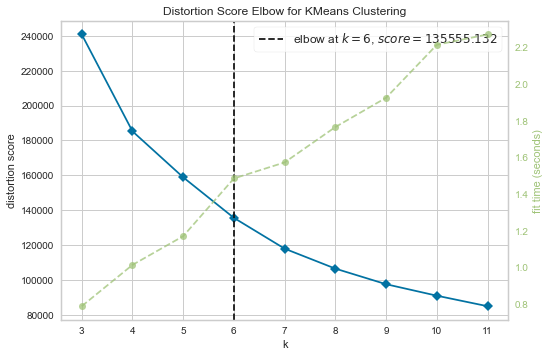

C:\Users\Luis\AppData\Roaming\Python\Python37\site-packages\sklearn\base.py:213: FutureWarning: From version 0.24, get_params will raise an AttributeError if a parameter cannot be retrieved as an instance attribute. Previously it would return None.
  FutureWarning)


KElbowVisualizer(ax=<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>,
                 k=None, model=None)

In [874]:
X = donors_rfm.loc[:, ['Recency_score','Frequency_score', 'Monetary_score']]
kelbow_visualizer(KMeans(init='k-means++', n_init=15, max_iter=300, random_state=1), X, k=(3,12),
                 timing = False)

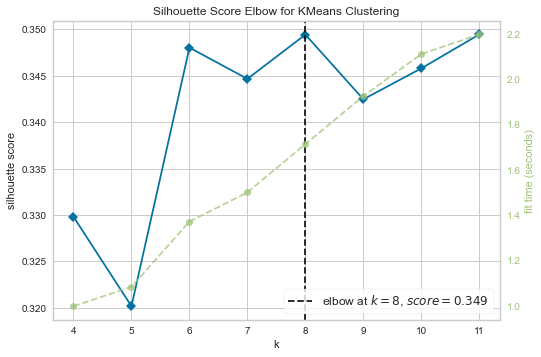

<AxesSubplot:title={'center':'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [875]:
X = donors_rfm.loc[:, ['Recency_score','Frequency_score', 'Monetary_score']]
model = KMeans(init='k-means++', n_init=15, max_iter=300, random_state=1)
visualizer = KElbowVisualizer(
    model, k=(4,12), metric='silhouette', timing = False
)

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure

In [876]:
RFM_table = donors_rfm.groupby(['Cluster_RFM']).agg(['mean'])
RFM_table['Total'] = RFM_table.loc[:,['Recency_score','Frequency_score', 'Monetary_score']].sum(axis = 1)
RFM_table = round(RFM_table.sort_values(by = 'Total',ascending = False),2)
RFM_table

,Recency_score,Frequency_score,Monetary_score,Total
,mean,mean,mean,
Cluster_RFM,,,,
1,4.57,4.54,4.59,13.70
7,2.38,4.62,4.43,11.43
6,4.46,4.18,2.29,10.93
5,3.90,2.44,3.60,9.94
4,1.44,2.89,4.44,8.77
2,1.95,3.40,2.42,7.77
0,4.01,1.41,1.38,6.80
3,1.41,1.37,1.55,4.33


In [880]:
bins = [1,7,6,5,4,2,0,3]
labels = ['Best Customers', 'Almost lost Customers', 'Loyal Customers','New Customers','Almost lost cheap Customers','Lost Customers','New cheap Customers','Lost Cheap Customers']
donors_rfm['Customer_RFM'] = donors_rfm['Cluster_RFM'].map(dict(zip(bins, labels)))


In [895]:
RFM_table = donors_rfm.groupby(['Customer_RFM']).agg(['mean'])
RFM_table['Total'] = RFM_table.loc[:,['Recency_score','Frequency_score', 'Monetary_score']].sum(axis = 1)
RFM_table = round(RFM_table.sort_values(by = 'Total',ascending = False),2)
RFM_table

,Recency_score,Frequency_score,Monetary_score,Cluster_RFM,Total
,mean,mean,mean,mean,
Customer_RFM,,,,,
Best Customers,4.57,4.54,4.59,1,13.70
Almost lost Customers,2.38,4.62,4.43,7,11.43
Loyal Customers,4.46,4.18,2.29,6,10.93
New Customers,3.90,2.44,3.60,5,9.94
Almost lost cheap Customers,1.44,2.89,4.44,4,8.77
Lost Customers,1.95,3.40,2.42,2,7.77
New cheap Customers,4.01,1.41,1.38,0,6.80
Lost Cheap Customers,1.41,1.37,1.55,3,4.33


<AxesSubplot:xlabel='None-None', ylabel='Customer_RFM'>

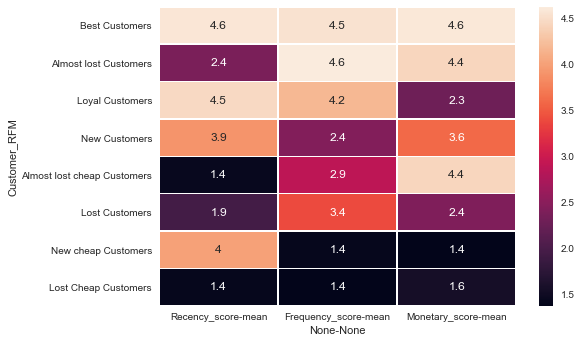

In [938]:
sns.heatmap(RFM_table.loc[:,['Recency_score','Frequency_score', 'Monetary_score']], annot=True, linewidths=.5)

<AxesSubplot:xlabel='Customer_RFM', ylabel='Count'>

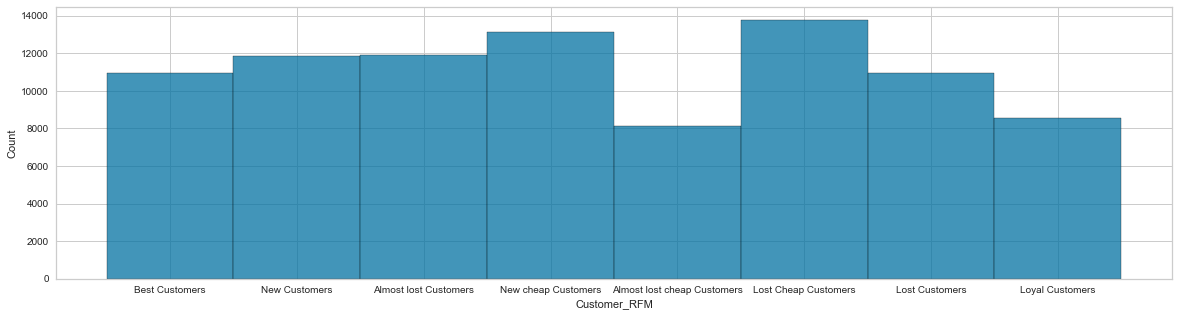

In [923]:
plt.figure(figsize=(20, 5))
sns.histplot(donors_rfm, x="Customer_RFM")

# Behavior analysis

In [940]:
donors['Customer_RFM'] = donors['Cluster_RFM'].map(dict(zip(bins, labels)))
promotion_features = donors[metric_features].loc[:,'Just labels': 'Notepad with labels'].columns.to_list()
promotion_features.append('Customer_RFM')
Promotion_behave = donors[promotion_features].groupby(['Customer_RFM']).mean()
round(Promotion_behave,2)

,Just labels,Calendars with stickers,Blank folding cards with labels,Blank cards with labels,Thank you cards with labels,Christmas Cards with labels,General Greeting Cards with Labels,Notepad with labels
Customer_RFM,,,,,,,,
Almost lost Customers,11.48,7.67,7.18,10.21,7.71,11.38,4.67,8.20
Almost lost cheap Customers,12.51,5.52,6.26,10.48,7.05,10.46,4.49,7.14
Best Customers,10.29,7.51,5.32,8.86,15.63,9.35,13.36,11.33
Lost Cheap Customers,5.21,1.21,0.49,4.15,1.54,5.64,1.35,2.49
Lost Customers,5.71,3.19,2.14,4.86,2.53,6.20,2.10,3.80
Loyal Customers,4.09,3.21,1.08,3.37,6.91,4.09,6.63,4.95
New Customers,7.21,7.89,0.84,2.90,9.13,5.86,8.91,8.83
New cheap Customers,1.57,3.35,0.06,0.48,7.82,2.19,7.82,4.25


<AxesSubplot:ylabel='Customer_RFM'>

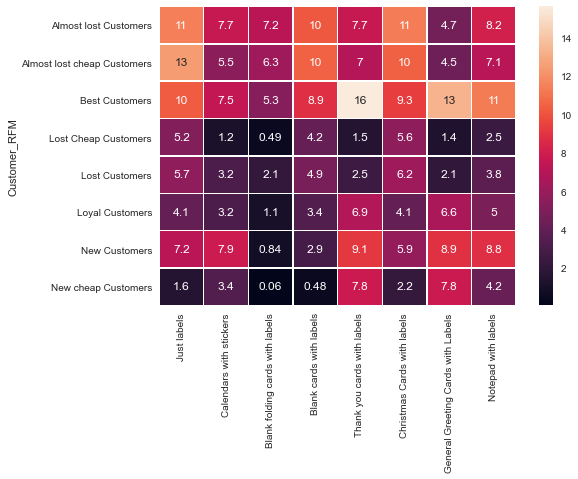

In [941]:
sns.heatmap(round(Promotion_behave,2), annot=True, linewidths=.5)

In [893]:
donors['Customer_RFM'] = donors['Cluster_RFM'].map(dict(zip(bins, labels)))
promotion_features_count = donors[metric_features].loc[:,'Just labels_count':'Notepad with labelss_count'].columns.to_list()
promotion_features_count.append('Customer_RFM')
Promotion_behave_count = donors[promotion_features_count].groupby(['Customer_RFM']).sum()
round(Promotion_behave_count,2)

,Just labels_count,Calendars with stickers_count,Blank folding cards with labels_count,Blank cards with labels_count,Thank you cards with labels_count,Christmas Cards with labels_count,General Greeting Cards with Labels_count,Notepad with labelss_count
Customer_RFM,,,,,,,,
Almost lost Customers,10171.0,6765.0,6968.0,10440.0,7606.0,10494.0,4636.0,7628.0
Almost lost cheap Customers,4059.0,1873.0,2254.0,3842.0,2513.0,3434.0,1653.0,2423.0
Best Customers,8395.0,6271.0,4775.0,8294.0,12474.0,8198.0,10416.0,9254.0
Lost Cheap Customers,4071.0,1012.0,426.0,3330.0,1344.0,4534.0,1210.0,2071.0
Lost Customers,5910.0,3409.0,2251.0,5490.0,3141.0,6341.0,2616.0,4155.0
Loyal Customers,5294.0,4033.0,1755.0,5007.0,7913.0,5389.0,7443.0,6157.0
New Customers,4397.0,4732.0,555.0,2137.0,5165.0,3719.0,5053.0,5241.0
New cheap Customers,1520.0,2901.0,70.0,578.0,6094.0,2047.0,6085.0,3504.0


<AxesSubplot:ylabel='Customer_RFM'>

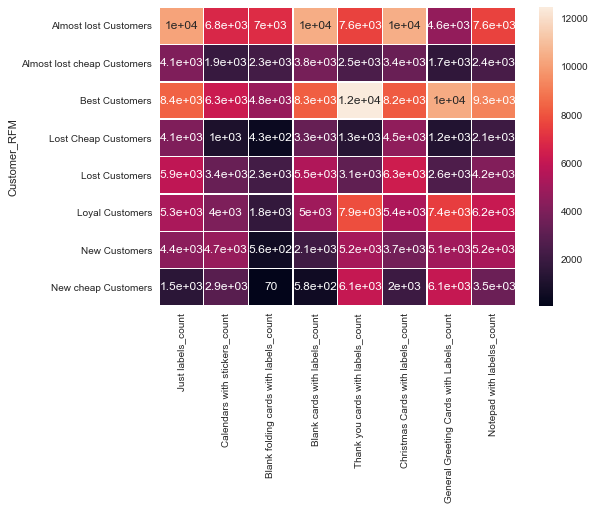

In [942]:
sns.heatmap(round(Promotion_behave_count,2), annot=True, linewidths=.5)

In [1008]:
age_features = donors[metric_features].loc[:,'AGE'].name
age_features.append('Customer_RFM')
age_behavior = donors[age_features].groupby(['Customer_RFM']).mean()
round(id_behavior,2)

AttributeError: 'str' object has no attribute 'append'

In [953]:
id_features = donors[metric_features].loc[:,'INCOME':'WEALTH2'].columns.to_list()
id_features.append('Customer_RFM')
id_behavior = donors[id_features].groupby(['Customer_RFM']).mean()
round(id_behavior,2)

,INCOME,WEALTH1,HIT,MALEMILI,MALEVET,VIETVETS,WWIIVETS,LOCALGOV,STATEGOV,FEDGOV,WEALTH2
Customer_RFM,,,,,,,,,,,
Almost lost Customers,3.77,5.06,3.29,1.05,30.57,29.86,32.39,6.82,4.50,3.15,4.87
Almost lost cheap Customers,4.07,5.40,3.35,0.94,30.60,30.09,32.56,6.84,4.54,3.03,5.20
Best Customers,3.82,5.16,3.60,0.97,30.75,29.35,33.01,6.83,4.53,3.00,5.00
Lost Cheap Customers,4.01,5.21,3.20,1.07,30.52,30.21,32.46,6.86,4.53,3.20,5.01
Lost Customers,3.76,5.02,3.46,1.03,30.65,29.87,32.79,6.85,4.66,3.11,4.80
Loyal Customers,3.59,4.86,3.73,0.96,30.82,29.15,33.64,6.88,4.59,3.01,4.69
New Customers,3.96,5.25,3.26,0.90,30.58,29.68,32.89,6.95,4.54,3.07,5.06
New cheap Customers,3.92,5.11,3.21,0.99,30.30,29.85,32.42,6.91,4.57,3.12,4.95


In [952]:
cat_features = donors[non_metric_features].columns.to_list()
cat_features.append('Customer_RFM')
cat_behavior = donors[cat_features].groupby(['Customer_RFM']).mean()
round(cat_behavior,2)

,x0_B,x1_,x1_E,x1_P,x2_,x2_0,x2_1,x2_X,x3_X,x4_X,...,x38_C,x38_R,x38_S,x38_T,x38_U,x39_,x39_1,x39_2,x39_3,x39_4
Customer_RFM,,,,,,,,,,,,,,,,,,,,,
Almost lost Customers,0.02,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.09,0.03,...,0.21,0.21,0.22,0.21,0.12,0.03,0.28,0.50,0.18,0.02
Almost lost cheap Customers,0.02,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.09,0.01,...,0.20,0.20,0.25,0.20,0.13,0.02,0.34,0.47,0.15,0.02
Best Customers,0.02,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.10,0.07,...,0.20,0.21,0.23,0.20,0.12,0.03,0.29,0.49,0.17,0.02
Lost Cheap Customers,0.01,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.06,0.01,...,0.20,0.20,0.24,0.21,0.13,0.02,0.31,0.48,0.17,0.02
Lost Customers,0.01,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.07,0.01,...,0.21,0.22,0.22,0.21,0.12,0.02,0.27,0.50,0.19,0.02
Loyal Customers,0.01,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.06,0.02,...,0.22,0.24,0.21,0.20,0.11,0.02,0.24,0.51,0.21,0.02
New Customers,0.02,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.07,0.02,...,0.19,0.20,0.24,0.20,0.14,0.02,0.32,0.47,0.16,0.02
New cheap Customers,0.01,0.99,0.0,0.01,0.0,1.0,0.0,0.0,0.05,0.01,...,0.20,0.21,0.23,0.20,0.13,0.02,0.30,0.48,0.18,0.02


In [1003]:
donors_scaled['Customer_RFM'] = donors_scaled['Cluster_RFM'].map(dict(zip(bins, labels)))
pca_features = donors_scaled[pc_features].columns.to_list()
pca_features.append('Customer_RFM')
pca_behavior = donors_scaled[pca_features].groupby(['Customer_RFM']).mean()
round(pca_behavior,2)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9
Customer_RFM,,,,,,,,,,
Almost lost Customers,0.14,-0.10,0.09,0.10,-0.28,-0.11,-1.90,0.55,1.02,-0.34
Almost lost cheap Customers,-0.75,0.37,-0.10,-0.01,0.32,0.09,0.12,0.19,0.06,-0.08
Best Customers,0.01,0.11,0.36,0.11,-0.18,-0.26,-2.08,0.66,1.16,-0.42
Lost Cheap Customers,-0.23,0.02,-0.34,-0.06,0.16,0.30,1.82,-0.58,-0.98,0.35
Lost Customers,0.37,-0.34,0.20,0.09,-0.12,-0.05,-0.21,-0.05,0.01,0.09
Loyal Customers,0.88,-0.35,0.49,0.04,-0.41,-0.37,-1.07,0.16,0.41,-0.05
New Customers,-0.32,0.28,-0.07,-0.11,0.23,0.05,0.54,-0.09,-0.24,0.02
New cheap Customers,-0.01,0.01,-0.40,-0.11,0.19,0.20,1.86,-0.54,-0.97,0.29


# PCA Cluster

In [ ]:
kmeans = KMeans(init='k-means++', n_clusters=8, n_init=15, max_iter=300, random_state=1)

In [ ]:
donors_pca = donors_scaled[pc_features]
kmeans.fit(donors_pca)

In [ ]:
donors_rfm['Cluster_PCA'] = kmeans.labels_

In [ ]:
RFM_table = donors_rfm.groupby(['Cluster_PCA']).agg(['mean'])
RFM_table['Total'] = RFM_table.loc[:,['Recency_score','Frequency_score', 'Monetary_score']].sum(axis = 1)
RFM_table = round(RFM_table.sort_values(by = 'Total',ascending = False),2)
RFM_table